In [14]:
import torch

# Rely on transformation functions in torch
import torchvision.transforms as transforms
from torchvision.io import read_image
import pandas as pd # for data manipulation
import torch.nn as nn # nn: neural network module
import os
import warnings
import numpy as np
import seaborn as sns # to visualize data
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics as sk_met
from torchmetrics.classification import MulticlassF1Score
import matplotlib.pyplot as plt

import performancetest as pt

# Note: if there is no nvidia gpu, set cuda:0 to cpu
warnings.filterwarnings('ignore')
DEVICE = 'cuda:0'

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, filter_fn=None):
        
        # Read images using pandas
        self.img_labels = pd.read_csv(annotations_file, sep=' ', header=None)
        if filter_fn is not None:
            self.img_labels = self.img_labels[self.img_labels[19] == filter_fn]
        
        # Save image directory
        self.img_dir = img_dir
        
        # Saving transformation
        self.transform = transform
        self.target_transform = target_transform

    # Return the number of images 
    def __len__(self):
        return len(self.img_labels)
    
    # Constructs the image path using 
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        cat = {'mono': 0, 'poly': 1, np.nan: 3}[self.img_labels.iloc[idx, 19]]
        return image, label, cat

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        # forced to call the constructor of the parent class to get ResidualBlock
        # working as a pytorch module
        super(ResidualBlock, self).__init__()
        
        # Self.conv1 is the main computation
        # 3x3 convolution batch normalization and ReLU 
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU()) # Using ReLU to fix vanishing gradient problem
        
        # Also a 3x3 convolution batch but takes in conv1's output to refine conv1's features
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        
        self.downsample = downsample # Optional downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    # Transform input data into output predictions     
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        # Constructed 4 residual layers
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 4)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        m_x = torch.softmax(self.fc(x), dim=-1)

        return m_x

In [5]:
dataset = CustomImageDataset('.\elpv\labels.csv', 'elpv/', transform=transforms.Compose([
                transforms.ToPILImage(), 
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ]),
                            target_transform=lambda x: int(x * 3))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.75), int(len(dataset) * 0.25)])
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Create an instance of the resNet model which is moved to DEVICE (idk how to get this working for AMD)
model = ResNet(ResidualBlock, [3, 4, 3, 4]).to(DEVICE)

# Learning rate (common starting point, too high and the model might fail coverage)
lr = 0.001
# Set to 100 passes through entire dataset
epochs = 100

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = 0.001, momentum=0.9) 

In [6]:
def process(model, loss_fn, optimizer, epochs, train_dataloader, test_datalodaer):
    for epoch in range(epochs):
        metric = MulticlassF1Score(num_classes=4, average='macro').to('cuda:0')
        steps = 0
        acc_loss = 0.0
        for image, label, cat in train_dataloader:
            image = image.to('cuda:0')
            label = label.to('cuda:0')
            optimizer.zero_grad()
            outputs = model(image)
            loss = loss_fn(outputs, label)
            loss.backward()
            optimizer.step()
            steps += 1
            acc_loss += loss.item()
        print(f'Epoch: {epoch} | Train Loss: {acc_loss / steps}')
        
        with torch.no_grad():
            steps = 0
            acc_loss = 0.0
            for image, label, cat in test_dataloader:
                image = image.to('cuda:0')
                label = label.to('cuda:0')
                outputs = model(image)
                loss = loss_fn(outputs, label)
                steps += 1
                acc_loss += loss.item()
                metric.update(torch.argmax(outputs, dim=-1), label)
            print(f'Epoch: {epoch} | Test Loss: {acc_loss / steps} | Test F1: {metric.compute()}')

        

In [7]:
process(model, loss, optimizer, epochs, train_dataloader, test_dataloader)

Epoch: 0 | Train Loss: 1.2181833684444427
Epoch: 0 | Test Loss: 1.197030484676361 | Test F1: 0.17843137681484222
Epoch: 1 | Train Loss: 1.1622876152396202
Epoch: 1 | Test Loss: 1.1964598894119263 | Test F1: 0.17843137681484222
Epoch: 2 | Train Loss: 1.1644317582249641
Epoch: 2 | Test Loss: 1.196351130803426 | Test F1: 0.17843137681484222
Epoch: 3 | Train Loss: 1.1618431732058525
Epoch: 3 | Test Loss: 1.1961602767308552 | Test F1: 0.17843137681484222
Epoch: 4 | Train Loss: 1.1614684537053108
Epoch: 4 | Test Loss: 1.1957021951675415 | Test F1: 0.17843137681484222
Epoch: 5 | Train Loss: 1.1595026403665543
Epoch: 5 | Test Loss: 1.1915096640586853 | Test F1: 0.18436852097511292
Epoch: 6 | Train Loss: 1.1433484926819801
Epoch: 6 | Test Loss: 1.1530470649401348 | Test F1: 0.2451251745223999
Epoch: 7 | Train Loss: 1.1044257283210754
Epoch: 7 | Test Loss: 1.1124597787857056 | Test F1: 0.31747519969940186
Epoch: 8 | Train Loss: 1.0796173587441444
Epoch: 8 | Test Loss: 1.091609259446462 | Test F1

Combined All Probs |  Accuracy: 0.69207  Precision: 0.68609  Recall: 0.40397  F1: 0.37025


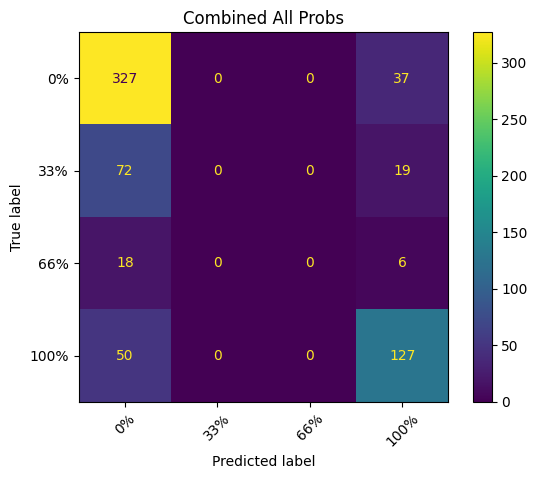

Mono Results     |  Accuracy: 0.86364  Precision: 0.86525  Recall: 0.838  F1: 0.84828
Poly Results     |  Accuracy: 0.82243  Precision: 0.78847  Recall: 0.78674  F1: 0.78759
Combined Results |  Accuracy: 0.83919  Precision: 0.82088  Recall: 0.80793  F1: 0.81373


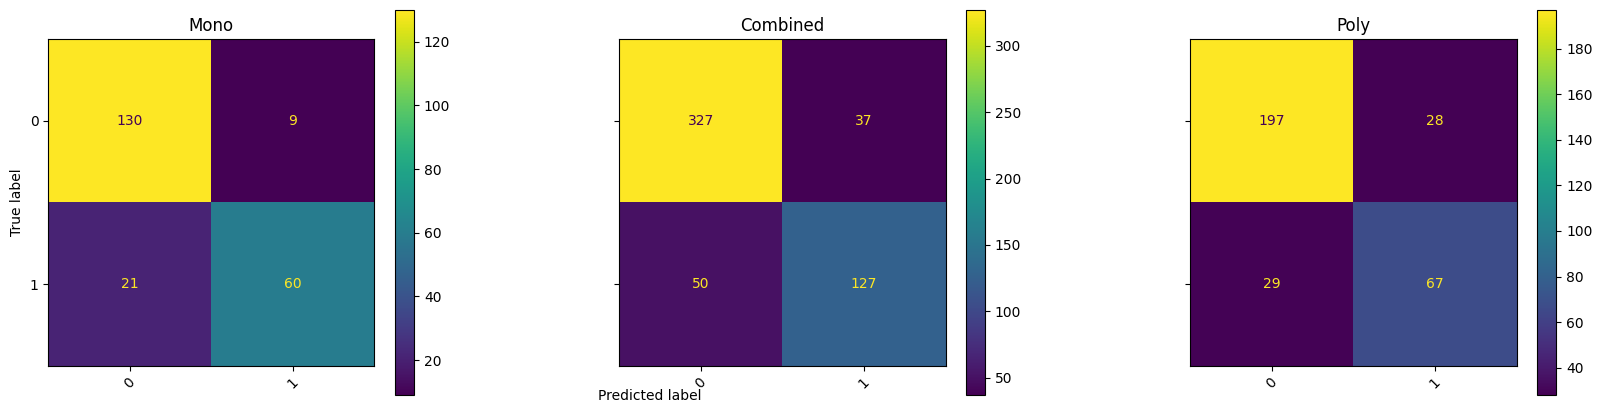

: 

In [22]:
with torch.no_grad():
    all_preds = []
    all_truth = []
    mono_preds = []
    mono_truth = []
    poly_preds = []
    poly_truth = []
    for image, label, cat in test_dataloader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(image)
        preds = torch.argmax(outputs, dim=-1)
        all_preds += preds.reshape(-1).tolist()
        all_truth += label.reshape(-1).tolist()
        for idx, c in enumerate(cat):
            if c == 0:
                mono_preds.append(preds[idx].cpu().item())
                mono_truth.append(label[idx].cpu().item())
            elif c == 1:
                poly_preds.append(preds[idx].cpu().item())
                poly_truth.append(label[idx].cpu().item())

pt.print_scores(all_truth, all_preds, "Combined All Probs")
cf_matrix = sk_met.confusion_matrix(all_truth, all_preds)
disp = sk_met.ConfusionMatrixDisplay(cf_matrix, display_labels=["0%", "33%", "66%", "100%"])
disp.plot(xticks_rotation=45)
disp.ax_.set_title("Combined All Probs")
disp.ax_.set_xlabel('Predicted label')
disp.ax_.set_ylabel('True label')
plt.show()


pt.display_results(mono_truth, poly_truth, mono_preds, poly_preds)